In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
from asyncio import Future
import asyncio
from asyncio.queues import Queue
import uvloop
asyncio.set_event_loop_policy(uvloop.EventLoopPolicy())

import tensorflow as tf
import numpy as np
import os
import sys
import random
import time
import argparse
from collections import deque, defaultdict, namedtuple
import scipy.stats
from threading import Lock
from concurrent.futures import ThreadPoolExecutor

gpu_num = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
from cchess_zero.gameboard import *

In [3]:
from cchess_zero import board_visualizer
import cv2

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from net import resnet

In [6]:
import common
from common import board
labels = common.board.create_uci_labels()

In [7]:
from cchess_zero import mcts

In [42]:
from cchess import *
from common import board
import common
from game_convert import boardarr2netinput

In [9]:
uci_labels = common.board.create_uci_labels()
class GameState():
    def __init__(self):
        self.statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
        self.currentplayer = 'w'
        self.ys = '9876543210'[::-1]
        self.xs = 'abcdefghi'
        self.pastdic = {}
        self.maxrepeat = 0
        self.lastmove = ""
    def get_king_pos(self):
        board = self.statestr.replace("1", " ")
        board = board.replace("2", "  ")
        board = board.replace("3", "   ")
        board = board.replace("4", "    ")
        board = board.replace("5", "     ")
        board = board.replace("6", "      ")
        board = board.replace("7", "       ")
        board = board.replace("8", "        ")
        board = board.replace("9", "         ")
        board = board.split('/')

        for i in range(3):
            pos = board[i].find('K')
            if pos != -1:
                K = "{}{}".format(self.xs[pos],self.ys[i])
        for i in range(-1,-4,-1):
            pos = board[i].find('k')
            if pos != -1:
                k = "{}{}".format(self.xs[pos],self.ys[i])
        return K,k
            
    def game_end(self):
        #if self.statestr.find('k') == -1:
        #    return True,'w'
        #elif self.statestr.find('K') == -1:
        #    return True,'b'
        wk,bk = self.get_king_pos()
        if self.maxrepeat >= 3 and (self.lastmove[-2:] != wk and self.lastmove[-2:] != bk):
            return True,self.get_current_player()
        
        targetkingdic = {'b':wk,'w':bk}
        moveset = GameBoard.get_legal_moves(self.statestr,self.get_current_player())
        
        targetset = set([i[-2:] for i in moveset])
        
        targ_king = targetkingdic[self.currentplayer]
        if targ_king in targetset:
            return True,self.currentplayer
        return False,None
    
    def get_current_player(self):
        return self.currentplayer
    
    def do_move(self,move):
        self.lastmove = move
        self.statestr = GameBoard.sim_do_action(move,self.statestr)
        if self.currentplayer == 'w':
            self.currentplayer = 'b'
        elif self.currentplayer == 'b':
            self.currentplayer = 'w'
        self.pastdic.setdefault(self.statestr,0)
        self.pastdic[self.statestr] += 1
        self.maxrepeat = max(self.maxrepeat,self.pastdic[self.statestr])
    
def policy_value_fn(state):
    bb = BaseChessBoard(state.statestr)
    statestr = bb.get_board_arr()
    net_x = np.transpose(boardarr2netinput(statestr,state.get_current_player()),[1,2,0])
    net_x = np.expand_dims(net_x,0)
    
    with graph.as_default():
        policyout,valout = sess.run([net_softmax,value_head],feed_dict={X:net_x,training:False})
        policyout,valout = policyout[0],valout[0][0]
    
    legal_move = GameBoard.get_legal_moves(state.statestr,state.get_current_player())
    #if state.currentplayer == 'b':
    #    legal_move = board.flipped_uci_labels(legal_move)
    legal_move = set(legal_move)
    
    action_probs = []
    for move,prob in zip(uci_labels,policyout):
        if state.currentplayer == 'b':
            move = board.flipped_uci_labels([move])[0]
        if move in legal_move:
            action_probs.append((move,prob))
    action_probs = sorted(action_probs,key=lambda x:x[1])
    return action_probs, valout

In [10]:
(sess,graph),((X,training),(net_softmax,value_head)) = resnet.get_model('models/5_7_resnet_joint-two_stage/model_57',labels,GPU_CORE=[gpu_num])

0
[None, 10, 9, 256]
[None, 10, 9, 256]
[None, 10, 9, 256]
[None, 10, 9, 256]
inside res net [None, 10, 9, 256]
INFO:tensorflow:Restoring parameters from models/5_7_resnet_joint-two_stage/model_57


In [11]:
from cchess import BaseChessBoard
from cchess_zero import mcts_pool,mcts_async

In [12]:
from collections import deque, defaultdict, namedtuple
QueueItem = namedtuple("QueueItem", "feature future")

In [13]:
queue = Queue(400)
async def push_queue( features,loop):
    future = loop.create_future()
    item = QueueItem(features, future)
    await queue.put(item)
    return future
async def prediction_worker(mcts_policy_async):
    q = queue
    while mcts_policy_async.num_proceed < mcts_policy_async._n_playout:
        if q.empty():
            await asyncio.sleep(1e-3)
            continue
        item_list = [q.get_nowait() for _ in range(q.qsize())]
        #print("processing : {} samples".format(len(item_list)))
        features = np.concatenate([item.feature for item in item_list],axis=0)
        
        action_probs, value = sess.run([net_softmax,value_head],feed_dict={X:features,training:False})
        for p, v, item in zip(action_probs, value, item_list):
            item.future.set_result((p, v))

In [14]:
async def policy_value_fn_queue(state,loop):
    bb = BaseChessBoard(state.statestr)
    statestr = bb.get_board_arr()
    net_x = np.transpose(boardarr2netinput(statestr,state.get_current_player()),[1,2,0])
    net_x = np.expand_dims(net_x,0)
    future = await push_queue(net_x,loop)
    await future
    policyout,valout = future.result()
    #policyout,valout = sess.run([net_softmax,value_head],feed_dict={X:net_x,training:False})
    #result = work.delay((state.statestr,state.get_current_player()))
    #while True:
    #    if result.ready():
    #        policyout,valout = result.get()
    #        break
    #    else:
    #        await asyncio.sleep(1e-3)
    #policyout,valout = policyout[0],valout[0][0]
    policyout,valout = policyout,valout[0]
    legal_move = GameBoard.get_legal_moves(state.statestr,state.get_current_player())
    #if state.currentplayer == 'b':
    #    legal_move = board.flipped_uci_labels(legal_move)
    legal_move = set(legal_move)
    legal_move_b = set(board.flipped_uci_labels(legal_move))
    
    action_probs = []
    if state.currentplayer == 'b':
        for move,prob in zip(uci_labels,policyout):
            if move in legal_move_b:
                move = board.flipped_uci_labels([move])[0]
                action_probs.append((move,prob))
    else:
        for move,prob in zip(uci_labels,policyout):
            if move in legal_move:
                action_probs.append((move,prob))
    action_probs = sorted(action_probs,key=lambda x:x[1])
    return action_probs, valout

In [57]:
mcts_policy_async = mcts_async.MCTS(policy_value_fn_queue,n_playout=1600,search_threads=1,virtual_loss=0.00,policy_loop_arg=True)
start = time.time()
acts_3, act_probs_3 = mcts_policy_async.get_move_probs(GameState(),temp=1e-2,verbose=False
                                                       ,predict_workers=[prediction_worker(mcts_policy_async)])
print(time.time() - start)

13.728056192398071


In [58]:
mcts_policy_async.select_time,mcts_policy_async.policy_time,mcts_policy_async.update_time

(5.435314893722534, 6.874048709869385, 1.0834743976593018)

In [59]:
start = time.time()
mcts_policy_nonasync = mcts.MCTS(policy_value_fn,n_playout=1600)
acts_2, act_probs_2 = mcts_policy_nonasync.get_move_probs(GameState(),temp=1e-2,verbose=False)
print(time.time() - start)

19.653907299041748


In [60]:
for i in mcts_policy_async._root._children:
    chi = mcts_policy_async._root._children[i]
    print(i,chi._n_visits)

i0i2 0
a0a2 0
e3e4 0
b2b3 0
e0e1 0
h2h3 0
h2h5 0
i0i1 0
h2h9 0
b2b5 0
c0a2 0
g0i2 0
b2b9 0
i3i4 0
a0a1 0
h2h6 0
b2b1 0
h2h1 0
h2i2 0
a3a4 0
h2h4 0
b2b6 0
b2a2 0
b2b4 0
f0e1 0
d0e1 0
h2g2 0
b2c2 0
h2c2 0
b2g2 1
h0i2 2
b0a2 2
h2f2 9
b2d2 9
b2f2 32
h2d2 32
h0g2 37
b0c2 40
g0e2 82
c0e2 98
c3c4 318
g3g4 332
h2e2 264
b2e2 341


In [61]:
for i in mcts_policy_nonasync._root._children:
    chi = mcts_policy_nonasync._root._children[i]
    print(i,chi._n_visits)

i0i2 0
a0a2 0
e3e4 0
b2b3 0
e0e1 0
h2h3 0
h2h5 0
i0i1 0
h2h9 0
b2b5 0
c0a2 0
g0i2 0
b2b9 0
i3i4 0
a0a1 0
h2h6 0
b2b1 0
h2h1 0
h2i2 0
a3a4 0
h2h4 0
b2b6 0
b2a2 0
b2b4 0
f0e1 0
d0e1 0
h2g2 0
b2c2 0
h2c2 0
b2g2 1
h0i2 2
b0a2 2
h2f2 9
b2d2 9
b2f2 32
h2d2 32
h0g2 37
b0c2 40
g0e2 82
c0e2 98
c3c4 318
g3g4 332
h2e2 264
b2e2 341


# make gif

In [105]:
! ls data/self-plays/ | tail

2018-05-17_22-27-18_812_mcts-mcts_w.cbf
2018-05-17_22-27-22_300_mcts-mcts_b.cbf
2018-05-17_22-27-43_785_mcts-mcts_w.cbf
2018-05-17_22-27-45_0_mcts-mcts_b.cbf
2018-05-17_22-28-03_213_mcts-mcts_b.cbf
2018-05-17_22-28-15_22_mcts-mcts_w.cbf
2018-05-17_22-28-29_875_mcts-mcts_b.cbf
2018-05-17_22-28-42_964_mcts-mcts_b.cbf
2018-05-17_22-28-48_188_mcts-mcts_w.cbf
2018-05-17_22-29-07_54_mcts-mcts_b.cbf


In [106]:
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
%matplotlib inline

In [107]:
files = os.listdir('data/self-plays/')

In [108]:
len(files),files[242]

(11130, '2018-05-17_11-29-10_7_mcts-mcts_w.cbf')

In [109]:
fname = files[245]
moves = cbf.cbf2move('data/self-plays/{}'.format(fname))
print(fname)

2018-05-16_19-44-30_49_mcts-mcts_b.cbf


In [151]:
from PIL import Image
import imageio
imgs_for_gif = []
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:20]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
imageio.mimsave('./data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

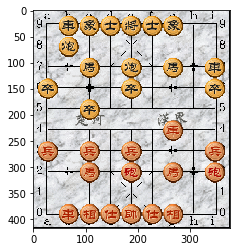

In [152]:
plt.imshow(board_visualizer.get_board_img(statestr))

In [114]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [115]:
display_gif('./data/gif/{}.gif'.format(fname[:-4]))

# mcts 可视化，使用百度脑图

In [131]:
import random

In [133]:
random.random() < 0.2

False

In [147]:
!mkdir data/mstc_vis

In [95]:
extra = {"font-weight":"bold","background":"#73a1bf","resource":[]}
def re_get_km_json(tree,statestr,is_root=True,c_puct=5,move=""):
    retval = {'data':{}}
    retval['data']['text'] = "Q {:.4f} u {:.4f} visit {} move {}".format(tree._Q,tree._u,tree._n_visits,move)
    visits = []
    chind_keys = []
    
    childern_mks = []
    for one_chind_key in tree._children:
        if tree._children[one_chind_key]._n_visits == 0:
            continue
        visits.append(tree._children[one_chind_key]._n_visits)
        chind_keys.append(one_chind_key)
        childern_mks.append(re_get_km_json(tree._children[one_chind_key]
                                            ,GameBoard.sim_do_action(one_chind_key,statestr)
                                            ,move=one_chind_key
                                          )
                           )
    if visits:
        visits = np.asarray(visits)
        childern_mks[np.argmax(visits)]['data'].update(extra)
    retval['children'] = childern_mks
        
    return retval

def get_km_json(mstc_policy,statestr,c_puct=5):
    rootdic = re_get_km_json(mstc_policy._root,statestr,c_puct=5)
    retdata = {
            "root":rootdic,
            "template": "default",
            "theme": "fresh-blue",
            "version": "1.4.43"
        }
    return retdata

In [153]:
mcts_policy_async = mcts_async.MCTS(policy_value_fn_queue,n_playout=400,search_threads=16,virtual_loss=0.02,policy_loop_arg=True)
start = time.time()
gs = GameState()
gs.statestr = statestr
acts_3, act_probs_3 = mcts_policy_async.get_move_probs(gs,temp=1e-2,verbose=False
                                                       ,predict_workers=[prediction_worker(mcts_policy_async)])
print(time.time() - start)

1.9959697723388672


In [155]:
datajson = get_km_json(mcts_policy_async,statestr)#GameState().statestr)

In [156]:
datajson.keys()

dict_keys(['root', 'template', 'theme', 'version'])

In [157]:
import json

In [158]:
root._children['a0a1']._n_visits

0

In [159]:
with open('data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)

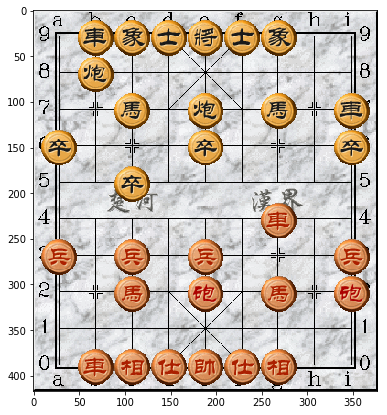

In [160]:
plt.figure(figsize=(7,7,))
plt.imshow(board_visualizer.get_board_img(statestr))